\newpage

# Question

**Libraries**

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,  f1_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import IterativeImputer
from sklearn import metrics

/var/folders/x5/76f9krq13bqb6cdssvpdq_yc0000gn/T/ipykernel_19133/2788166968.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Question 1

In [2]:
data_path = './chronic_kidney_disease.arff'

# Read the arff data file
with open(data_path, 'r') as f:
    data = f.readlines()
    # Extract Headers
    header = [line for line in data if line.startswith('@attribute')]
    # Parse Headers
    header_to_type = {}
    for line in header:
        colname = line.split()[1][1:-1]
        coltype = line.split()[2]
        if coltype == "numeric":
            header_to_type[colname] = float
        else:
            header_to_type[colname] = str
    # Extract Data
    data = [line.strip() for line in data if line.strip() and not line.startswith('@')]
    data = [line.split(',') for line in data]
    # Fix length 26 columns
    data = [[x.strip() for x in line if x.strip()] for line in data]


# Create a pandas dataframe
df = pd.DataFrame(data, columns=list(header_to_type.keys()))
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,...,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


Based on this dataset, we can define the classification problem as predicting whether the patient is a Chronic Kidney Disease patient or not. To describe in details. Each dependent variable "class" is based on all other independent variables. In other words, the dataset consists of a collection of medical records of patients. Age, blood pressure(bp), specific gravity(sg), etc. are the features in dataset. These features will be used to predict the dependent variable (ckd or norckd).

# Q2

In [3]:
df_clean = df.copy()


# Convert numeric columns to float, and categorical columns to string
for col, col_type in header_to_type.items():
    if col_type == float:
        # Convert ? to np.nan
        df_clean[col] = df_clean[col].replace('?', np.nan)
        df_clean[col] = df_clean[col].astype(float)
    else:
        df_clean[col] = df_clean[col].astype(str)
        # Convert ? to np.nan
        df_clean[col] = df_clean[col].replace('?', np.nan)

df_clean.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1,0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4,0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2,3,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4,0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2,0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


# Q3

In [4]:
# Full statistics
df_clean.describe(include='all')

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
count,391.000000,388.000000,353,354,351,248,335,396,396,356.000000,...,329.000000,294.000000,269.000000,398,398,398,399,399,399,400
unique,NaN,NaN,5,6,6,2,2,2,2,NaN,...,NaN,NaN,NaN,2,2,2,2,2,2,2
top,NaN,NaN,1.020,0,0,normal,normal,notpresent,notpresent,NaN,...,NaN,NaN,NaN,no,no,no,good,no,no,ckd
freq,NaN,NaN,106,199,290,201,259,354,374,NaN,...,NaN,NaN,NaN,251,261,364,317,323,339,250
mean,51.483376,76.469072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148.036517,...,38.884498,8406.122449,4.707435,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,17.169714,13.683637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.281714,...,8.990105,2944.474190,1.025323,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.000000,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.000000,...,9.000000,2200.000000,2.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,42.000000,70.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.000000,...,32.000000,6500.000000,3.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,55.000000,80.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.000000,...,40.000000,8000.000000,4.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,64.500000,80.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163.000000,...,45.000000,9800.000000,5.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Descriptive statistics
df_clean.describe()

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


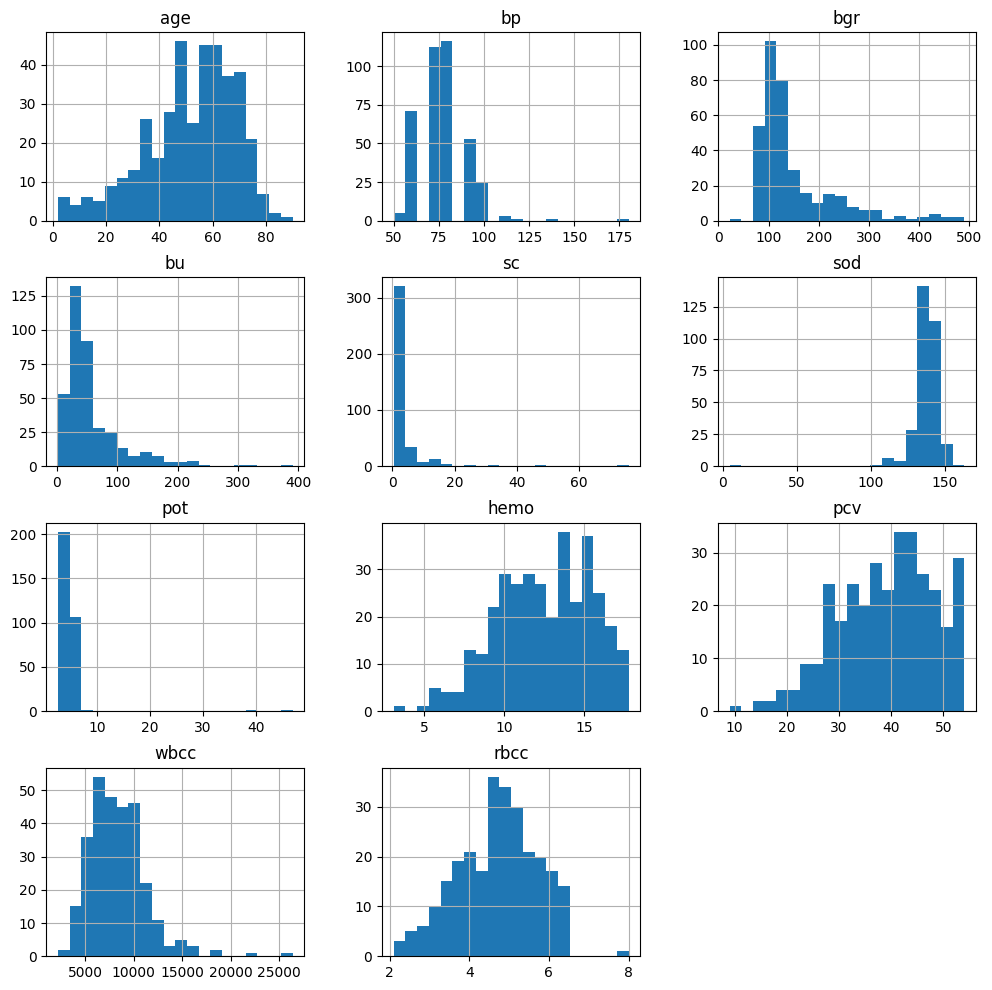

In [6]:
# Distribution of descriptive statistics
df_numeric = df_clean.select_dtypes(include=[np.number])
df_numeric.hist(figsize=(12, 12), bins=20)
plt.show()

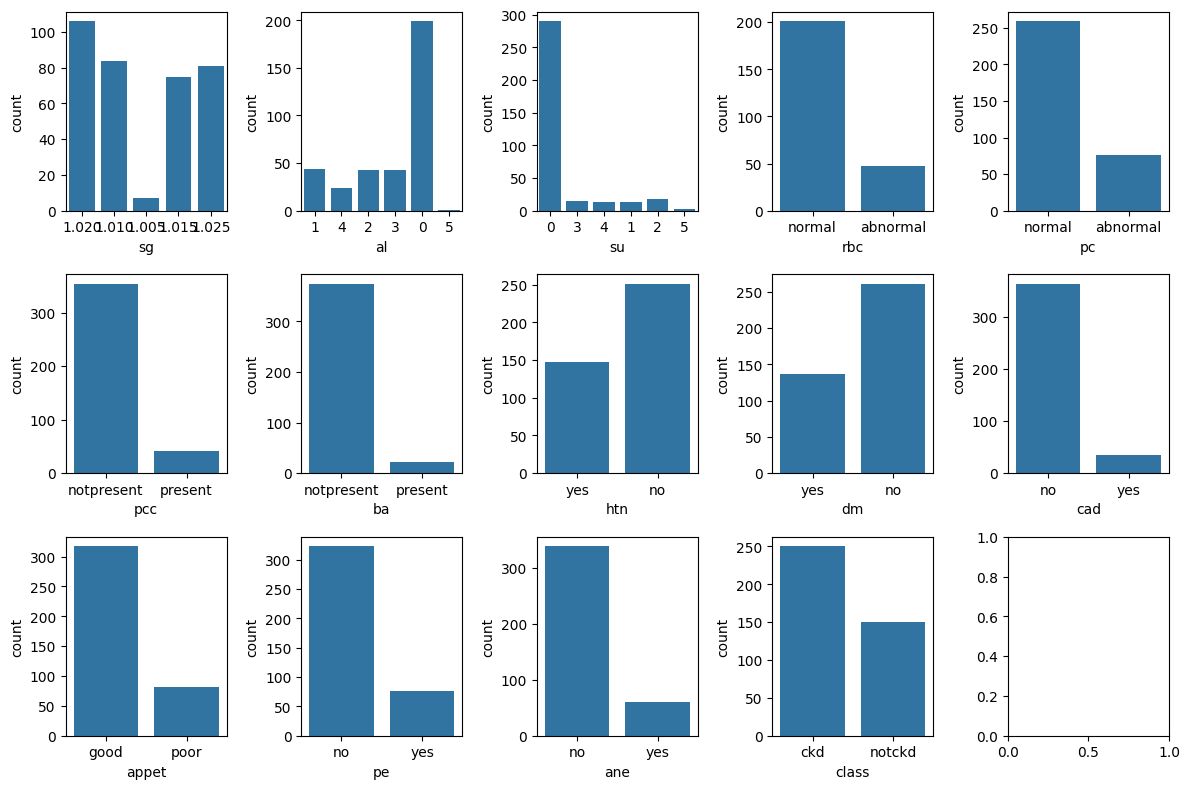

In [7]:
# Distribution of categorical statistics
df_categorical = df_clean.select_dtypes(include=[object])
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    if i < len(df_categorical.columns):
        sns.countplot(x=df_categorical.columns[i], data=df_categorical, ax=ax)
plt.tight_layout()
plt.show()

In [8]:
df_clean.shape

(400, 25)

In [9]:
df_clean.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [10]:
df_clean.dtypes

age      float64
bp       float64
sg        object
al        object
su        object
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class     object
dtype: object

**Statements**
1. There are 400 observations and 25 variables in the dataset.

2. Independent variables in the dataset are age, blood pressure, specific gravity, albumin, sugar, red blood cells, pus cell, pus cell clumps, bacteria, blood glucose random, blood urea, serum creatinine, sodium, potassium, hemoglobin, packed cell volume, white blood cell count, red blood cell count, hypertension, diabetes mellitus, coronary artery disease, appetite, pedal edema, anemia, and target variable "class"(ckd or ckdnot)

3. The distribution of categoricals is not balanced, for many categorical columns, there is a dominant category that has a much higher frequency than the others. And the overall distribution of numerical columns is fairly normal, no significant outlier is observed from the data.

4. About variable type, there are 11 floating numbers like age, bp, etc. and others are objects like class, ane, and so on.

# Q4

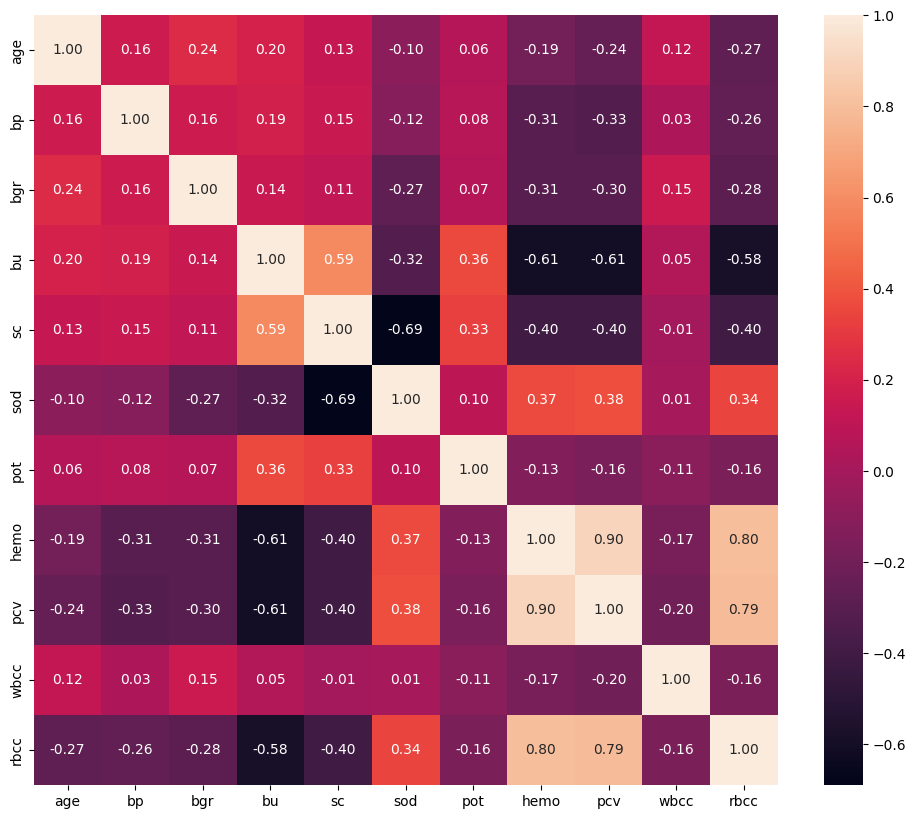

In [11]:
# Check correlation between numeric columns
corr = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

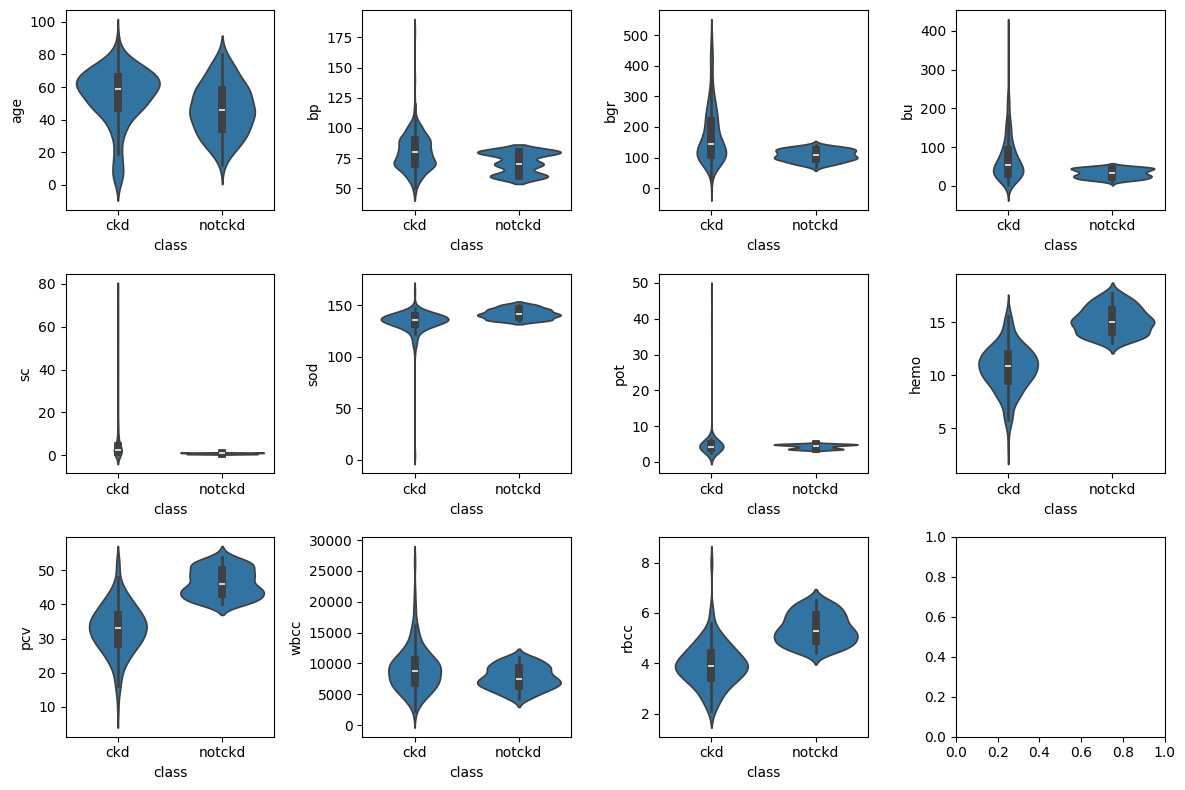

In [12]:
# violin plot of numerical columns
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    if i < len(df_numeric.columns):
        sns.violinplot(x='class', y=df_numeric.columns[i], data=df_clean, ax=ax)
plt.tight_layout()
plt.show()

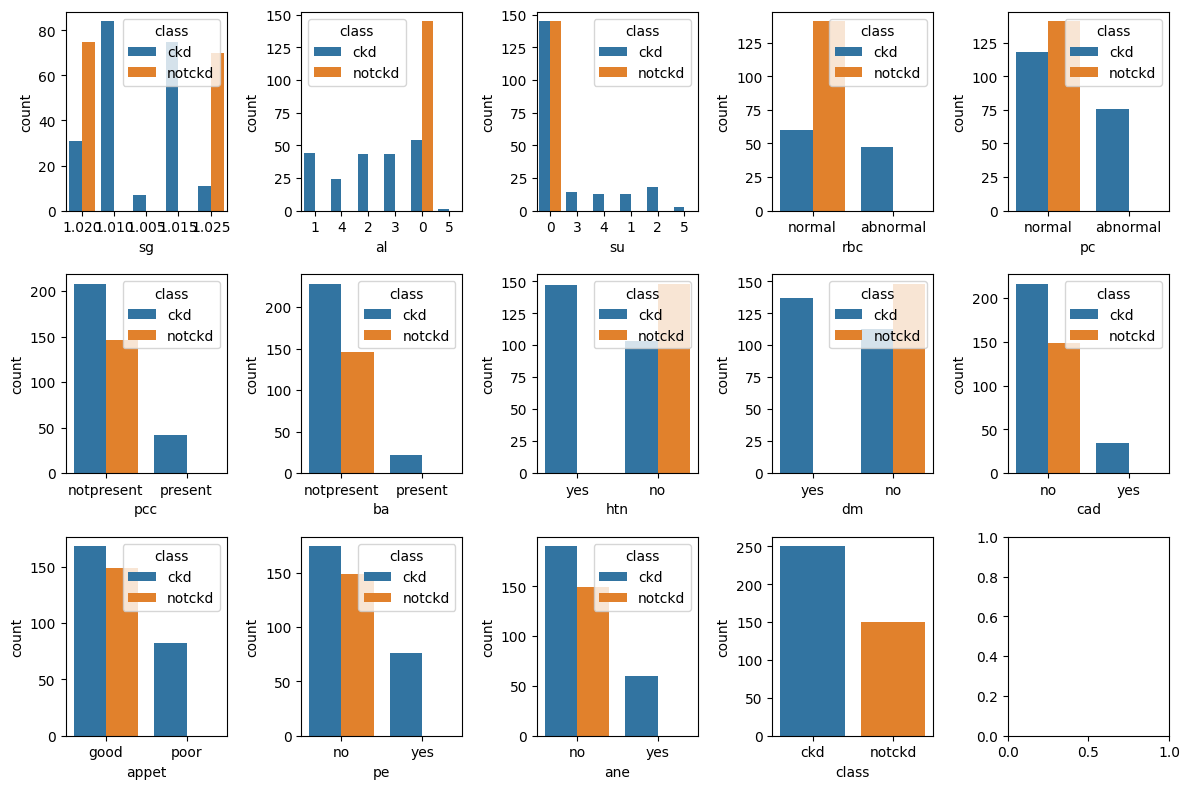

In [13]:
# Bar plot of each categorical column colored by class
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    if i < len(df_categorical.columns):
        sns.countplot(x=df_categorical.columns[i], data=df_clean, hue='class', ax=ax)
plt.tight_layout()
plt.show()

1. From the heatmap, we see that column "pcv", "hemo", "bu" are the major sources of correlation. We can consider to remove these columns to avoid multicollinearity. However, they can be useful for imputing missing values.

2. From the violin plot, we figure out all the numerical columns are visually related with the target column, that means we can achieve a good classification model out of these features.  The "pot" column is possibly a good feature, since some CKD patients appear to have very high potassium levels.

3. From the bar plots, all the categorical columns are also related to the target column. The count bar plot shows that the distribution of the categorical columns is different for both classes.

# Q5

In [14]:
# Identify columns with missing values
cols_with_missing_values = df_clean.columns[df_clean.isnull().any()].tolist()
print(cols_with_missing_values)

['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']


All features have missing values.

For **numerical columns**, a multivariate imputation method will be used, considering that many numerical columns are correlated with each other. For multivariate imputation, we will use the IterativeImputer from the sklearn library. This method is based on the MICE algorithm, which iteratively imputes the missing values of each feature using a simple regression model from other features.

For **categorical columns**, notice that from the previous plots, we see that each categorical column is very important for the classification, that is, appearance of some categories can be a strong indicator of whether the patient is a CKD patient or not. Therefore, considering the importance of the categorical columns, no imputation will be performed. For later analysis, after we convert the categorical columns to dummy variables, missing values will fill the dummy columns with zeros, so that it will not affect our final conclusion about the indicators of the CKD patients.

Therefore:

In [ ]:
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
df_numeric = df_clean[numerical_cols]

imputer = IterativeImputer(estimator=LinearRegression())
df_clean.loc[:, numerical_cols] = imputer.fit_transform(df_numeric)

for col in df_clean.select_dtypes(include=[object]).columns:
    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Q6

To locate outliers, we can simply by looking at the boxplot of the numerical columns. Since numerical columns are mostly approximately normally distributed. Here are the following codes:

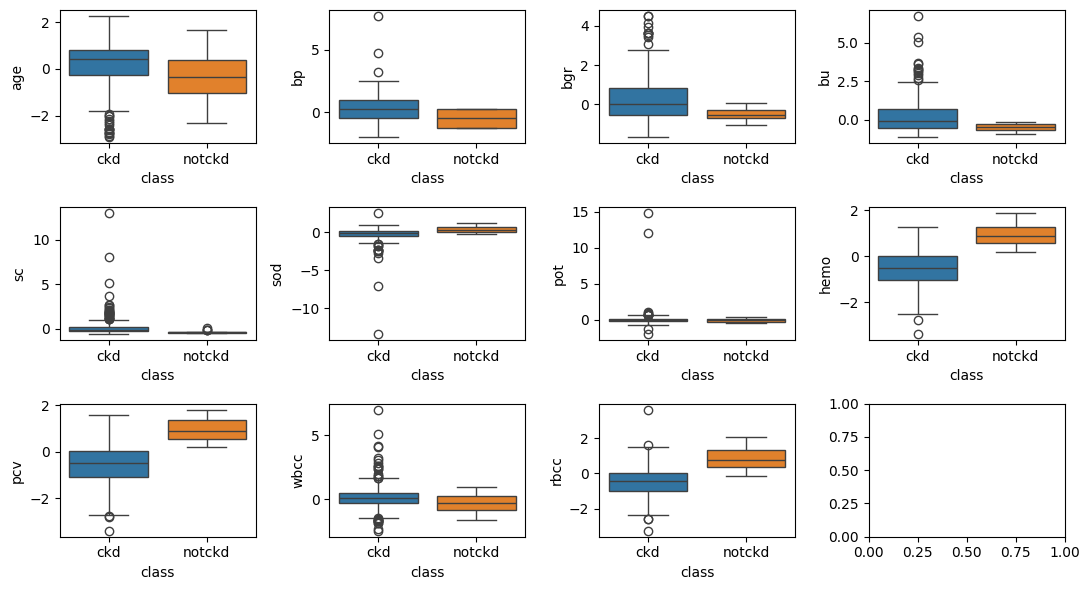

In [24]:
# Standardize the numeric columns
scaler = StandardScaler()
df_outlier = df_clean.copy()
df_outlier.loc[:, numerical_cols] = scaler.fit_transform(df_numeric)

# Box and whisker plot of standardized numeric columns
fig, axes = plt.subplots(3, 4, figsize=(11, 6))
for i, ax in enumerate(axes.flat):
    if i < len(df_numeric.columns):
        col = df_numeric.columns[i]
        sns.boxplot(x='class', y=col, data=df_outlier, hue = 'class', ax=ax)

plt.tight_layout()
plt.show()

We choose not to addressing outliers. Although outliers are present in the dataset, we will not handle them. This is because observing from the box plot, the appearance of outliers always happen within a single class. This means it is most likely not a systematic error, but rather a natural variation of the data. Moreover, these outliers are also strong indicators of the CKD patients, so we will keep them in the dataset.

# Q7

In [16]:
# use label encoder to encode categorical columns
import warnings
warnings.filterwarnings('ignore')

le = LabelEncoder()
df_encoded = df_clean.copy(deep=True)

df_encoded.drop(columns='class', inplace=True)

for col in df_encoded.select_dtypes(include=[object]).columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_encoded)

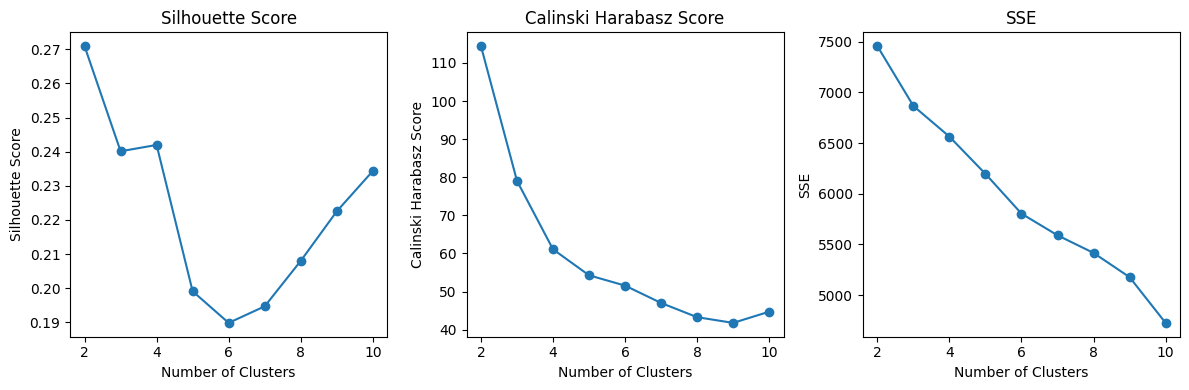

In [17]:
# use KMeans to cluster the data
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

silhouette_scores = []
calinski_harabasz_scores = []
sse = []

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(df_scaled)
    silhouette_scores.append(metrics.silhouette_score(df_scaled, kmeans.labels_))
    calinski_harabasz_scores.append(metrics.calinski_harabasz_score(df_scaled, kmeans.labels_))
    sse.append(kmeans.inertia_)

# plot the scores
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].plot(n_clusters, silhouette_scores, marker='o')
axes[0].set_title('Silhouette Score')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Silhouette Score')

axes[1].plot(n_clusters, calinski_harabasz_scores, marker='o')
axes[1].set_title('Calinski Harabasz Score')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Calinski Harabasz Score')

axes[2].plot(n_clusters, sse, marker='o')
axes[2].set_title('SSE')
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('SSE')

plt.tight_layout()
plt.show()

<Figure size 1200x1200 with 0 Axes>

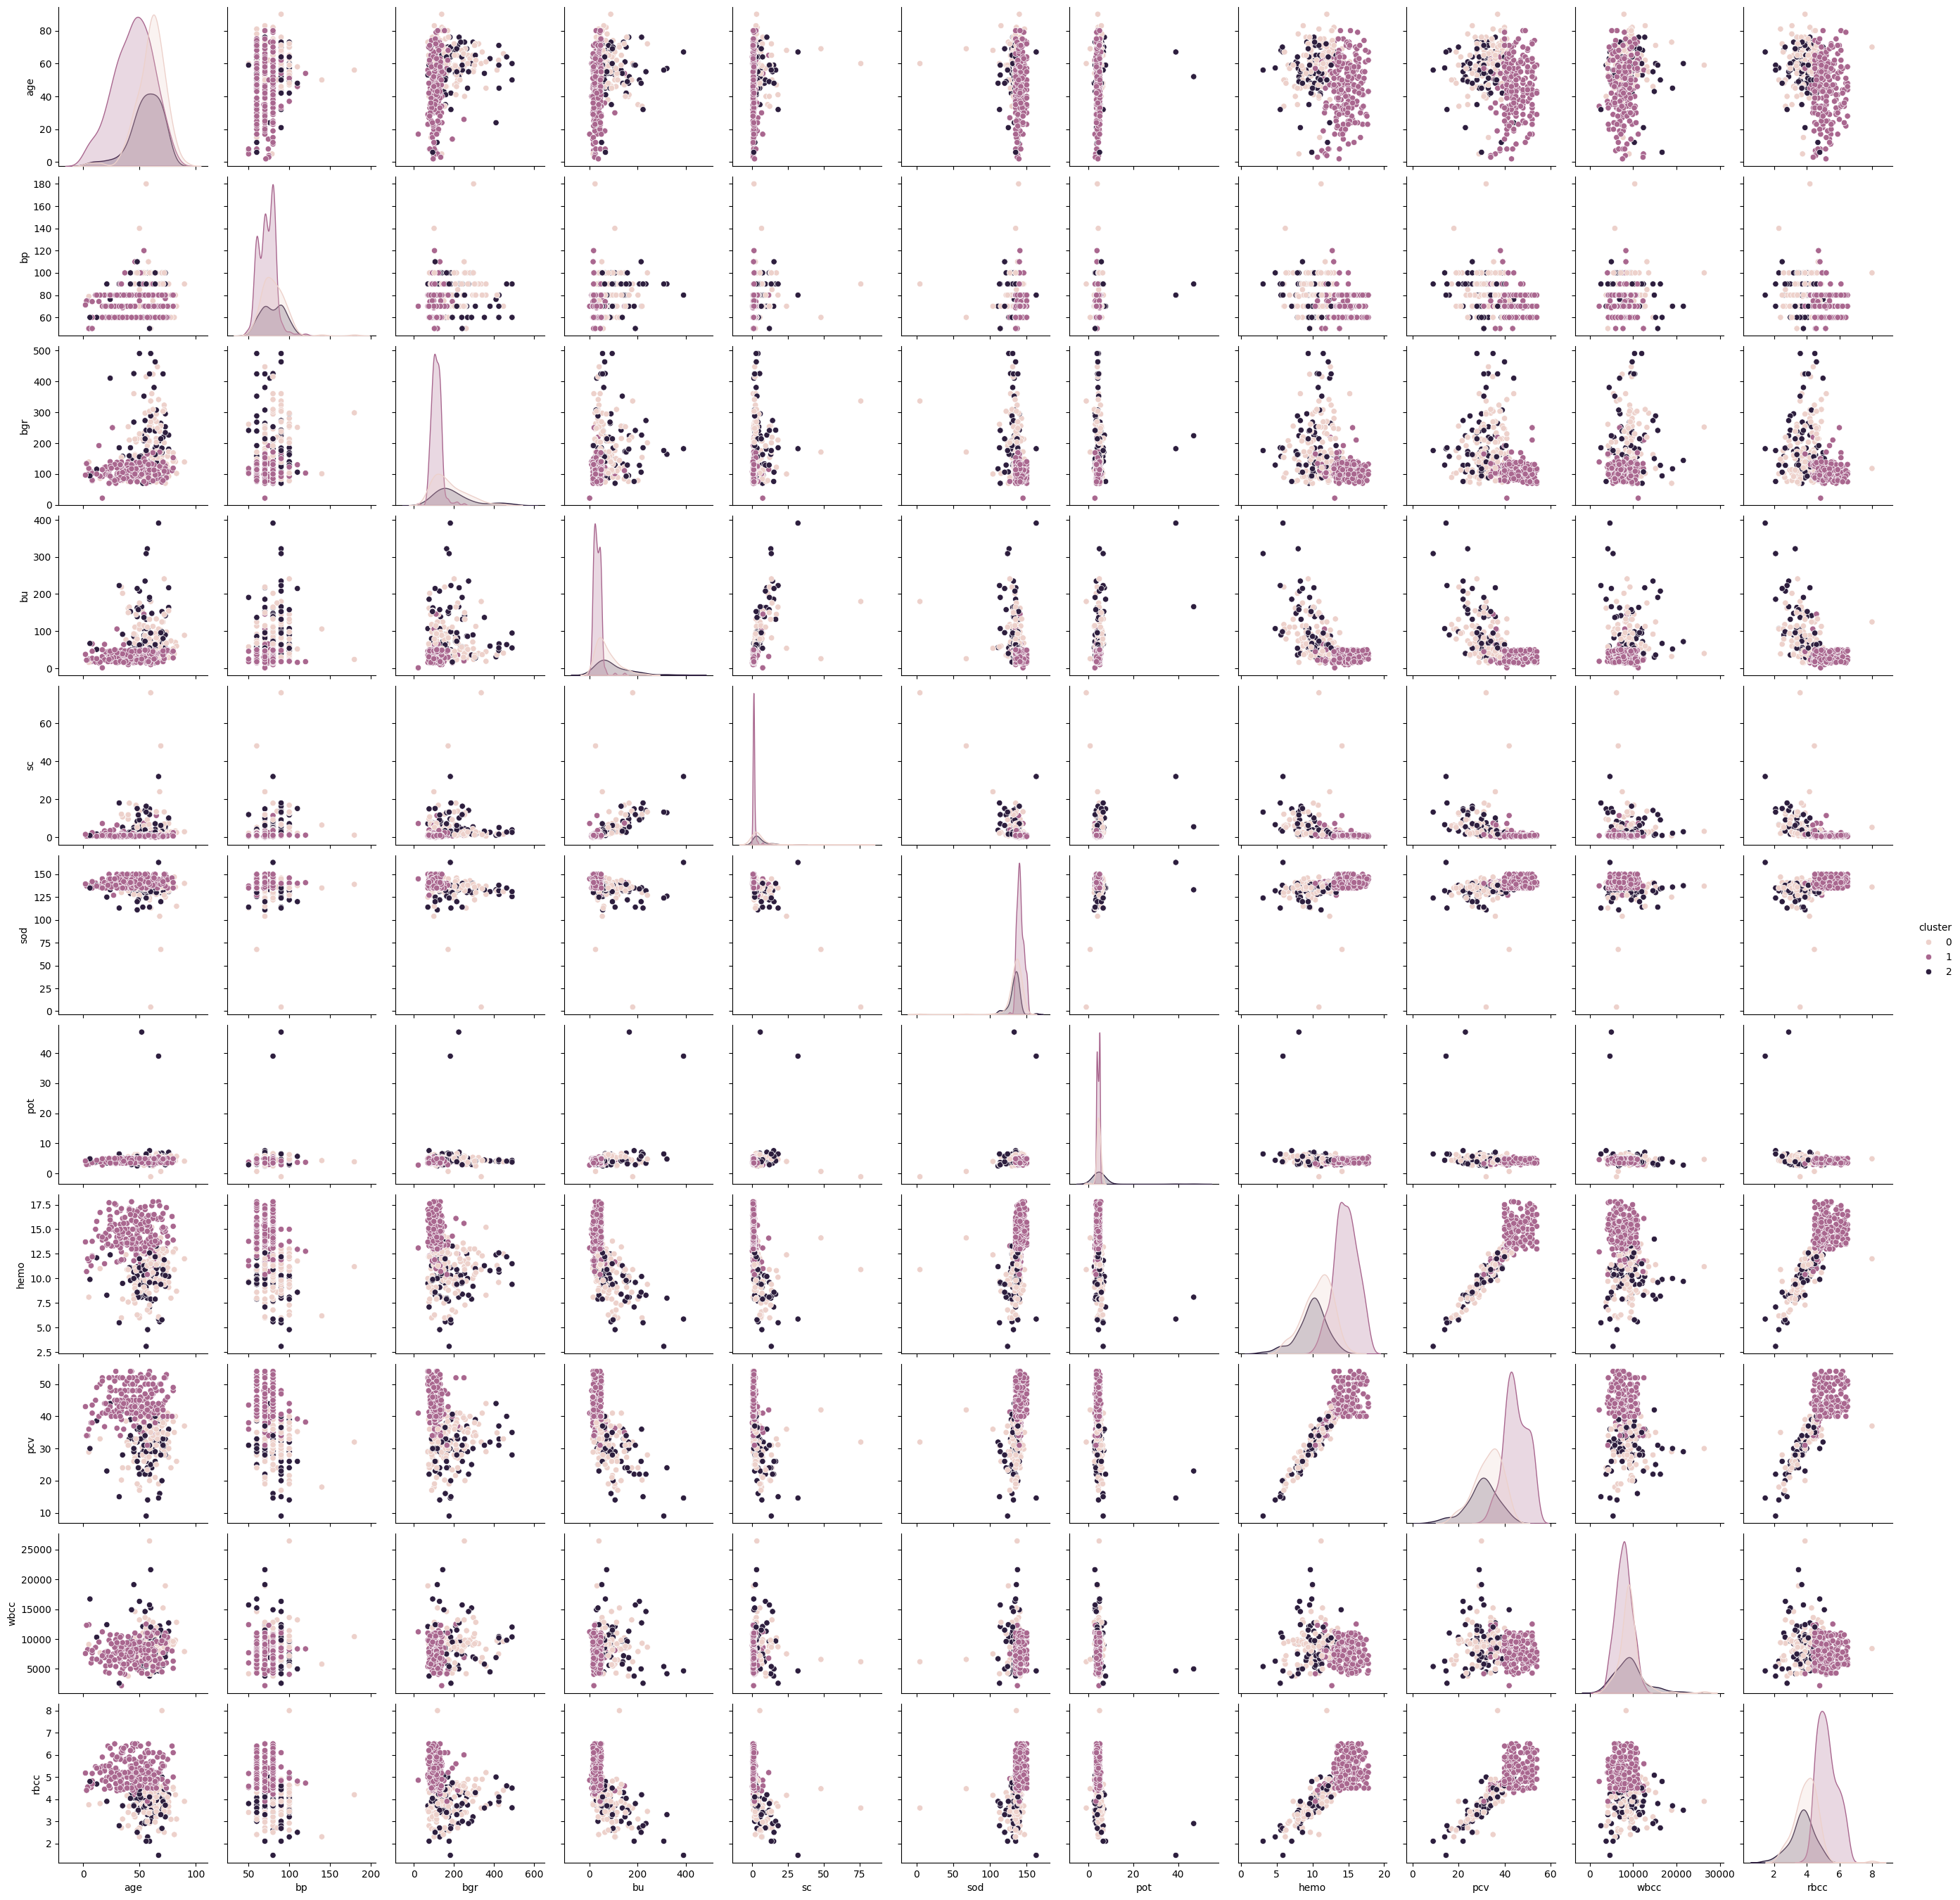

In [18]:
# select the number of clusters and fit the model
kmeans = KMeans(n_clusters=3, random_state=0)

kmeans.fit(df_scaled)

df_labels = df_clean.copy()

df_labels['cluster'] = kmeans.labels_

plt.figure(figsize=(12, 12))
sns.pairplot(df_labels, hue='cluster')
plt.show()

# Q8


In [19]:
# split the data into train and test sets
X = df_clean.drop(columns='class')
y = df_clean['class']

# use get_dummies to encode the categorical columns
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Q9

Two classifiers we choose are logistic regression and the random forest. To justify our selections, first reason is after explanatory data analysis, we can see that this dataset is fairly easy, since all the features are related to the target column, and there are no big outliers. Therefore, for better interpretability, we set the logistic regression as the base line model, and the random forest as the more complex model for a probe better predictive performance. Moreover random forest combines multiple descision trees so that can improve accuracy and reduce overfitting.

# Q10

For comparing the performance of the classifier, two metrics are accuracy and F1 score. Accuracy is the mostly used metric for classification problems. However, in this case, since the dataset is imbalanced, we still need to consider the precision and recall for the CKD patients. Therefore, the F1 score (the harmonic mean of precision and recall) will be better used when evaluating the performance of different models.

# Q11 and Q12

Since codes of Q11 can be included in (12) so we choose to combine these two questions. We also specify write where Q11 start.

In [20]:
# use standard scaler to scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# use logistic regression and random forest classifier to predict the class
# two classifier training

# logistic regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# random forest classifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [22]:
# use accuracy score、precision score、recall score、f1 score to evaluate the model
print('Logistic Regression')
print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print('F1 Score:', f1_score(y_test, y_pred_lr, average='weighted'))

print('\nRandom Forest Classifier')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('F1 Score:', f1_score(y_test, y_pred_rf, average='weighted'))

Logistic Regression
Accuracy: 0.9666666666666667
F1 Score: 0.9668174962292609

Random Forest Classifier
Accuracy: 0.975
F1 Score: 0.9750903550421658


**Q11 starts (also contain model selection in Q12)**

(0.0, 48)
(0.0748310258141496, 37)
(0.1496620516282992, 32)
(0.2244930774424488, 27)
(0.2993241032565984, 19)
(0.374155129070748, 17)
(0.4489861548848976, 13)
(0.5238171806990473, 10)
(0.5986482065131968, 9)
(0.6734792323273464, 7)
(0.748310258141496, 6)
(0.8231412839556457, 5)
(0.8979723097697953, 4)
(0.9728033355839448, 3)
(1.0476343613980945, 2)
(1.122465387212244, 2)
(1.1972964130263937, 1)
(1.2721274388405432, 1)
(1.3469584646546928, 1)
(1.4217894904688424, 1)


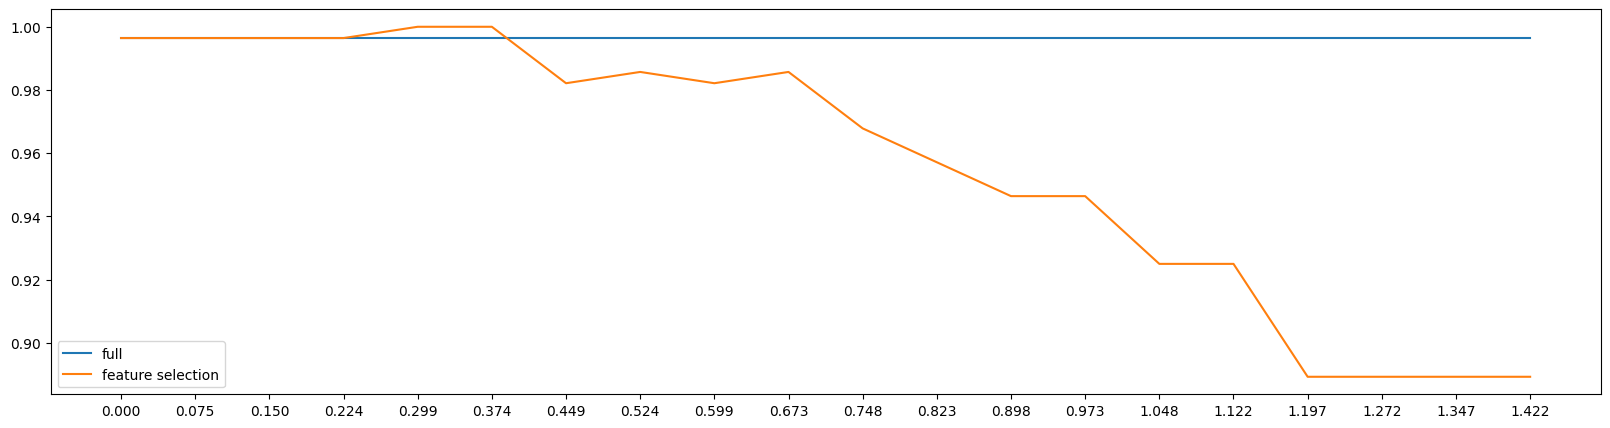

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

# Q11 - enhance performance of classifier
# use SelectFromModel to select features
fullx = []
fsx = []
threshold = np.linspace(0,np.max(abs(lr.fit(X_train,y_train).coef_)),20)
k=0
for i in threshold:
    X_embedded = SelectFromModel(lr,threshold=i).fit_transform(X_train,y_train)
    fullx.append(cross_val_score(lr,X_train,y_train,cv=5).mean())
    fsx.append(cross_val_score(lr,X_embedded,y_train,cv=5).mean())
    print((threshold[k],X_embedded.shape[1]))
    k+=1

plt.figure(figsize=(20,5))
plt.plot(threshold,fullx,label='full')
plt.plot(threshold,fsx,label='feature selection')
plt.xticks(threshold)
plt.legend()
plt.show()

(0.225, 27)
(0.23678947368421052, 26)
(0.24857894736842107, 26)
(0.2603684210526316, 24)
(0.2721578947368421, 23)
(0.2839473684210526, 23)
(0.2957368421052632, 19)
(0.3075263157894737, 19)
(0.3193157894736842, 19)
(0.33110526315789474, 19)
(0.34289473684210525, 17)
(0.3546842105263158, 17)
(0.3664736842105263, 17)
(0.37826315789473686, 16)
(0.3900526315789474, 16)
(0.4018421052631579, 15)
(0.41363157894736846, 15)
(0.4254210526315789, 13)
(0.4372105263157895, 13)
(0.449, 13)


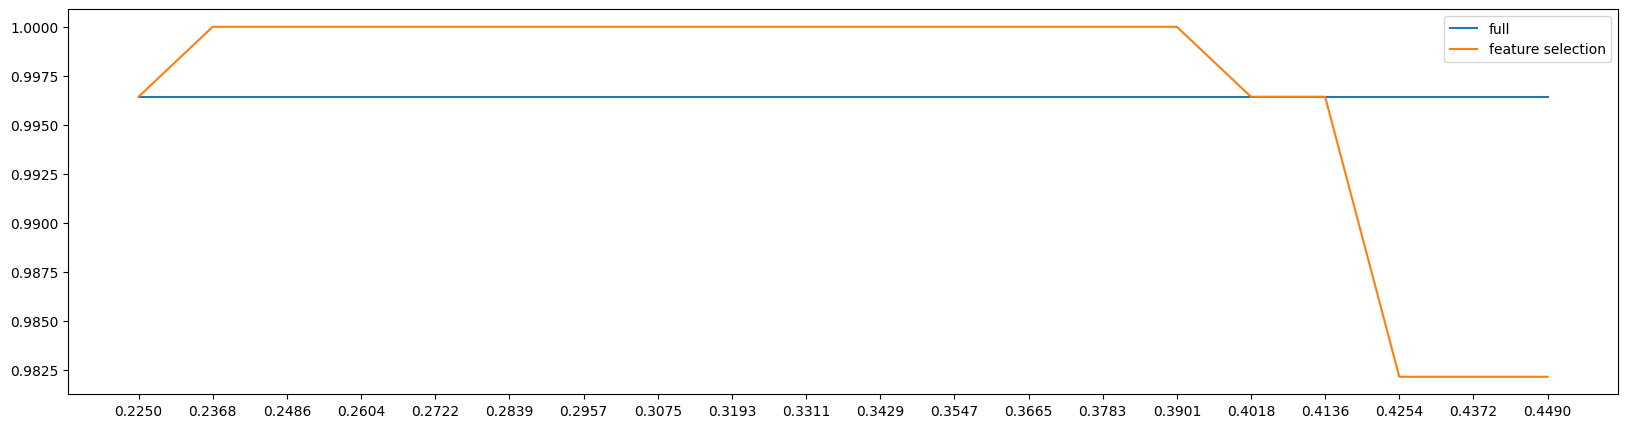

In [24]:
fullx = []
fsx = []
threshold = np.linspace(0.225,0.449,20)
k=0

for i in threshold:
    X_embedded = SelectFromModel(lr,threshold=i).fit_transform(X_train,y_train)
    fullx.append(cross_val_score(lr,X_train,y_train,cv=5).mean())
    fsx.append(cross_val_score(lr,X_embedded,y_train,cv=5).mean())
    print((threshold[k],X_embedded.shape[1]))
    k+=1

plt.figure(figsize=(20,5))
plt.plot(threshold,fullx,label='full')
plt.plot(threshold,fsx,label='feature selection')
plt.xticks(threshold)
plt.legend()
plt.show()

In [25]:
# select the best threshold
best_threshold = threshold[np.argmax(fsx)]
sfm = SelectFromModel(lr,threshold=best_threshold)
X_train_sfm = sfm.fit_transform(X_train,y_train)
X_test_sfm = sfm.transform(X_test)

In [26]:
X_train_sfm.shape, X_test_sfm.shape

((280, 26), (120, 26))

**Q11 ends**

In [27]:
# classifier comparision
lr = LogisticRegression(random_state=0)
lr.fit(X_train_sfm, y_train)
y_pred_lr = lr.predict(X_test_sfm)

rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_sfm, y_train)
y_pred_rf = rf.predict(X_test_sfm)

accuracy_score_lr = accuracy_score(y_test, y_pred_lr)
f1_score_lr = f1_score(y_test, y_pred_lr, average='weighted')

accuracy_score_rf = accuracy_score(y_test, y_pred_rf)
f1_score_rf = f1_score(y_test, y_pred_rf, average='weighted')

print('Logistic Regression')
print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print('F1 Score:', f1_score(y_test, y_pred_lr, average='weighted'))

print('\nRandom Forest Classifier')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('F1 Score:', f1_score(y_test, y_pred_rf, average='weighted'))

Logistic Regression
Accuracy: 0.975
F1 Score: 0.9750903550421658

Random Forest Classifier
Accuracy: 0.9666666666666667
F1 Score: 0.9668174962292609


# Findings:
1. The effect of the linear regression model has been improved, from the original 0.9666 to 0.975.
Redundant or highly correlated features are removed through feature selection, reducing multicollinearity problems and improving model prediction accuracy.

2. But the effect of random forest has declined. It shows that different methods of feature selection will produce different effects on different models.Random forest itself has certain feature selection capabilities, especially for high-dimensional data. Forced feature selection may eliminate features that would otherwise be beneficial to the model.

# Q13

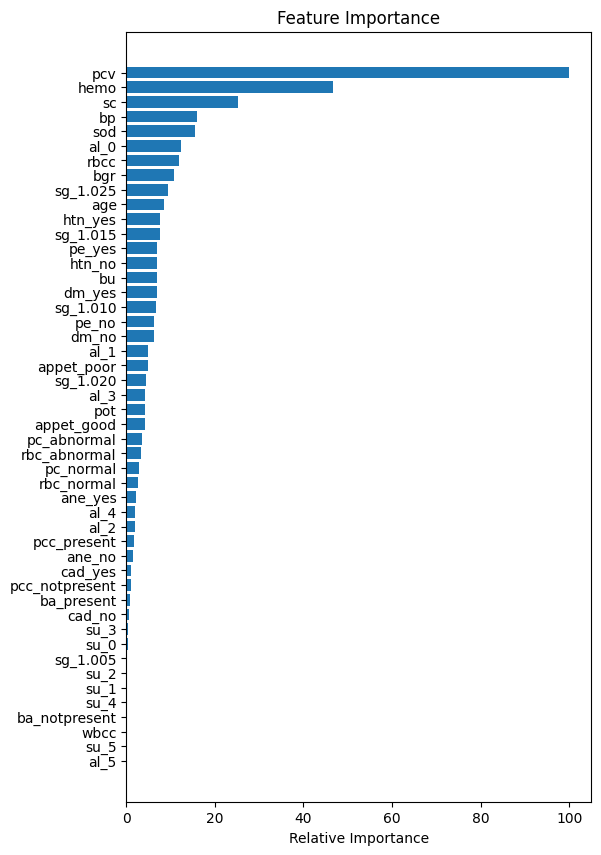

In [28]:
# use logistic regression to get the feature importance
lr = LogisticRegression(random_state=0)
lr.fit(X, y)

# get feature importance
feature_importance = np.abs(lr.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# sort feature importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# plot feature importance
plt.figure(figsize=(6, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

# Findings:
1. Using the logistic regression model to train all the data and calculate the importance of each variable. It can be seen that there are large differences in the importance of each variable.
2. Among them, pcv has the highest importance, followed by hemo and sc. If you further select variables, you can select them based on their importance and discard variables with lower importance, thereby improving the model effect.

# Q14

In [29]:
# use GridSearchCV to improve the model
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr = LogisticRegression(random_state=0)

# use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(lr, param_grid, cv=5)
grid_search.fit(X_train_sfm, y_train)

best_params = grid_search.best_params_

best_lr = grid_search.best_estimator_

y_pred_lr = best_lr.predict(X_test_sfm)

print('Best Hyperparameters:', best_params)

Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [30]:
accuracy_score_lr_gs = accuracy_score(y_test, y_pred_lr)
f1_score_lr_gs = f1_score(y_test, y_pred_lr, average='weighted')

print('Logistic Regression')
print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print('F1 Score:', f1_score(y_test, y_pred_lr, average='weighted'))

Logistic Regression
Accuracy: 0.9833333333333333
F1 Score: 0.9833759590792839


In [31]:
# random forest classifier
param_grid = {
    'n_estimators': list(range(20,101,10)),
    # 'max_depth': [3, 4, 5, None],
    # 'min_samples_split': [2, 3, 4],
    # 'min_samples_leaf': [1, 2, 3]
}

rf = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train_sfm, y_train)

best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

y_pred_rf = best_rf.predict(X_test_sfm)

print('Best Hyperparameters:', best_params)

Best Hyperparameters: {'n_estimators': 20}


In [32]:
accuracy_score_rf_gs = accuracy_score(y_test, y_pred_rf)
f1_score_rf_gs = f1_score(y_test, y_pred_rf, average='weighted')

print('\nRandom Forest Classifier')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('F1 Score:', f1_score(y_test, y_pred_rf, average='weighted'))


Random Forest Classifier
Accuracy: 0.9833333333333333
F1 Score: 0.9833759590792839


In [33]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest Classifier'],
    'Accuracy': [accuracy_score_lr, accuracy_score_rf],
    'F1 Score': [f1_score_lr, f1_score_rf],
    'Accuracy (GridSearchCV)': [accuracy_score_lr_gs, accuracy_score_rf_gs],
    'F1 Score (GridSearchCV)': [f1_score_lr_gs, f1_score_rf_gs]
})

results

,Model,Accuracy,F1 Score,Accuracy (GridSearchCV),F1 Score (GridSearchCV)
0,Logistic Regression,0.975000,0.975090,0.983333,0.983376
1,Random Forest Classifier,0.966667,0.966817,0.983333,0.983376


# Comparison:
1. After parameter tuning of the two models, the model effects have been improved. The accuracy and f1 score both reached 0.983, indicating that parameter tuning can effectively improve the model effect.
2. In addition, we can also add a combination of multiple parameters for parameter tuning, but this will increase the time cost, we should also consider that.

# Q15

# Contribution:

Yujia Sun: Completed questions 1,2,3,5,6, 9, and 10, and jointly completed question 4, 14. During the completion process, involved in the initial discussion for all the questions.

Xiangran Gong: Completed 7, 8, 11, 12, 13, and jointly completed question 4,14. During the completion process, involved in the initial discussion for all the questions.

# Q16

https://github.com/YS-02/Chronic-Kidney-Disease-Classification-Challenge.git

\newpage

## Grading scheme 

\begin{table}[H]
\begin{tabular}{p{0.15\textwidth}  p{0.65\textwidth}}
1.   & Answer [1]\\
2.   & Codes [2] \\
     & OR answer [2]\\
3.   & Codes [3] and answer [3]\\
4.   & Codes [2] and answer [3]\\
5.   & Codes [2]\\
     & OR answer [2]\\
6.   & Codes [2] \\
     & OR answer [2]\\
7.   & Codes [3] and Plot [1]\\
8.   & Codes [1]\\
9.   & Answers [2]\\
10.   & Describe the two metrics [2]\\
11.   & Codes [2] \\
      & these codes can be included in (12)\\
12.   & Codes (two classifiers training,\\
     & model selection for each classifier, \\
     & classifiers comparisons) [5] and answer [2]\\
13.   & Codes [1] and answers [2]\\
14.   & Codes and comparison will \\
     & give \textbf{bonus 2 points for the final grade}.\\
\end{tabular}
\end{table}

**The maximum point for this assignment is 39. We will convert this to 100%.**

**All group members will receive the same grade if they contribute to the same.**
